# Caso de Estudio: Predicci√≥n de √âxito en Campa√±as de Telemercadeo con Deep Learning

**Autor:** Luis E. Seijas

**Curso:** Deep Learning para Negocios

---

### 1. Descripci√≥n del Problema

En este proyecto, actuar√°s como Cient√≠fico de Datos para una instituci√≥n financiera. El banco necesita optimizar sus campa√±as de **telemercadeo** para ofrecer dep√≥sitos a plazo, un producto financiero clave. Cada llamada tiene un costo, y llamar a clientes que no est√°n interesados no solo es ineficiente, sino que tambi√©n puede generar una mala experiencia para el cliente.

**El objetivo principal es:**

> Construir un modelo de clasificaci√≥n basado en redes neuronales profundas que pueda predecir con alta precisi√≥n si un cliente suscribir√° (`'s√≠'`) o no (`'no'`) un dep√≥sito a plazo despu√©s de ser contactado.

Un modelo exitoso permitir√° al banco:
*  **Focalizar los esfuerzos:** Concentrar las llamadas en los clientes con mayor probabilidad de conversi√≥n.
*  **Reducir costos:** Minimizar el n√∫mero de llamadas innecesarias.
*  **Aumentar la tasa de √©xito:** Mejorar el retorno de inversi√≥n (ROI) de las campa√±as de marketing.

**Es importante considerar:** Los datos son una mezcla de informaci√≥n demogr√°fica, historial bancario y m√©tricas de la campa√±a. Tu tarea es procesar estos datos, dise√±ar una arquitectura de red neuronal efectiva y, finalmente, traducir tus resultados en recomendaciones de negocio accionables.

In [1]:
import tensorflow as tf

print(f"Versi√≥n de TensorFlow: {tf.__version__}")

gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Esta configuraci√≥n es una buena pr√°ctica para evitar que TensorFlow
        # reserve toda la memoria de la GPU desde el inicio.
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        print(f"‚úÖ GPU(s) detectada(s): {len(gpus)}. La configuraci√≥n se aplic√≥ correctamente.")
        print("TensorFlow utilizar√° la GPU para el entrenamiento.")
    except RuntimeError as e:
        # Este bloque se ejecuta si la GPU ya fue inicializada.
        print(f"‚ö†Ô∏è Error al configurar la GPU: {e}")
        print("La GPU ya estaba inicializada. Si necesitas cambiar la configuraci√≥n, reinicia el kernel.")
else:
    print("‚ùå No se detect√≥ ninguna GPU. El entrenamiento se realizar√° en la CPU.")

Versi√≥n de TensorFlow: 2.20.0
‚ùå No se detect√≥ ninguna GPU. El entrenamiento se realizar√° en la CPU.


#### 1.1. Carga de datos 



In [2]:
!pip install ucimlrepo

In [2]:
# -*- coding: utf-8 -*-
"""
Paso 1: Configuraci√≥n del entorno y carga de datos.

En este paso, instalaremos la librer√≠a recomendada para acceder al repositorio
de la UCI, importaremos las herramientas necesarias y cargaremos los datos.
"""

# 1. Instalaci√≥n de la librer√≠a de UCI (si no est√° instalada)
# Descomenta la siguiente l√≠nea y ejec√∫tala si es la primera vez que usas esta librer√≠a.
# !pip install ucimlrepo

# 2. Librer√≠as para manipulaci√≥n y an√°lisis de datos
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo 

# 3. Librer√≠as para visualizaci√≥n de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Configuraciones para una mejor visualizaci√≥n
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')

# 4. Carga del conjunto de datos usando el ID del repositorio
# ID 222 corresponde al dataset "Bank Marketing"
# Moro, S., Rita, P., & Cortez, P. (2014). Bank Marketing [Dataset]. 
# UCI Machine Learning Repository. https://doi.org/10.24432/C5K306.
bank_marketing = fetch_ucirepo(id=222) 

# Extracci√≥n de los datos en DataFrames de pandas
# X contiene las variables predictoras (features)
X = bank_marketing.data.features 
# y contiene la variable objetivo (target)
y = bank_marketing.data.targets 

# Para facilitar el an√°lisis exploratorio, uniremos X e y en un solo DataFrame
df = pd.concat([X, y], axis=1)

print("¬°Datos cargados exitosamente usando ucimlrepo!")
print(f"El conjunto de datos tiene {df.shape[0]} filas y {df.shape[1]} columnas.")

# 5. Primera visualizaci√≥n de los datos
# Usamos .head() para mostrar las primeras 5 filas.
print("\nPrimeras 5 filas del conjunto de datos:")
df.head()

¬°Datos cargados exitosamente usando ucimlrepo!
El conjunto de datos tiene 45211 filas y 17 columnas.

Primeras 5 filas del conjunto de datos:


age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married        NaN      no     1506     yes   no   
4   33           NaN   single        NaN      no        1      no   no   

  contact  day_of_week month  duration  campaign  pdays  previous poutcome   y  
0     NaN            5   may       261         1     -1         0      NaN  no  
1     NaN            5   may       151         1     -1         0      NaN  no  
2     NaN            5   may        76         1     -1         0      NaN  no  
3     NaN            5   may        92         1     -1         0      NaN  no  
4     NaN            5   may       198         1     -1         0      NaN  no

In [3]:
import numpy as np 

### 2. An√°lisis Exploratorio de Datos (EDA)

Antes de proceder con la construcci√≥n de un modelo, es imperativo realizar un An√°lisis Exploratorio de Datos (EDA). Este proceso consiste en la investigaci√≥n sistem√°tica del conjunto de datos para identificar patrones, detectar anomal√≠as, validar supuestos y extraer conclusiones iniciales mediante el uso de estad√≠sticas descriptivas y t√©cnicas de visualizaci√≥n.

Los objetivos de esta secci√≥n son:
1.  **Analizar la estructura y tipos de datos:** Identificar las variables, sus tipos (num√©ricas, categ√≥ricas) y evaluar la integridad de los datos.
2.  **Examinar la variable objetivo:** Cuantificar la distribuci√≥n de la variable de salida para identificar posibles sesgos, como el desbalance de clases.
3.  **Visualizar relaciones y distribuciones:** Investigar la relaci√≥n entre las variables predictoras y la variable objetivo.

In [4]:
# La librer√≠a nos da acceso directo a informaci√≥n valiosa sobre los datos.

# Mostramos la metadata del dataset
print("------ METADATA DEL DATASET ------")
print(bank_marketing.metadata)

# Mostramos la descripci√≥n de cada variable
print("\n------ INFORMACI√ìN DE LAS VARIABLES ------")
pd.set_option('display.max_rows', None) # Descomentar para ver todas las variables
print(bank_marketing.variables)

------ METADATA DEL DATASET ------
{'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 45211, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Occupation', 'Marital Status', 'Education Level'], 'target_col': ['y'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2014, 'last_updated': 'Fri Aug 18 2023', 'dataset_doi': '10.24432/C5K306', 'creators': ['S. Moro', 'P. Rita', 'P. Cortez'], 'intro_paper': {'ID': 277, 'type': 'NATIVE', 'title': 'A da

In [5]:
# -*- coding: utf-8 -*-
"""
Paso 2.1: Inspecci√≥n inicial de la calidad de los datos.

Verificaci√≥n de tipos de datos por columna y presencia de valores nulos.
"""

# El m√©todo .info() proporciona un resumen conciso del DataFrame,
# incluyendo el tipo de dato de cada columna y el conteo de valores no nulos.
print("------ Resumen del DataFrame ------")
df.info()

# Se realiza una comprobaci√≥n expl√≠cita de la suma de valores nulos.
print("\n------ Conteo de Valores Nulos por Columna ------")
print(df.isnull().sum())

------ Resumen del DataFrame ------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
 16  y            45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB

------ Conteo de Valores

In [6]:
pout_unique= df.poutcome.unique()
contact_unique = df.contact.unique()
print(pout_unique)
print(contact_unique)

[nan 'failure' 'other' 'success']
[nan 'cellular' 'telephone']


------ Conteo de Clases en la Variable Objetivo ------
y
no     39922
yes     5289
Name: count, dtype: int64

------ Porcentaje de Clases en la Variable Objetivo ------
Clase 'no': 88.30%
Clase 'yes': 11.70%


C:\Users\alejo\AppData\Local\Temp\ipykernel_21544\2873102656.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='y', data=df, palette=['#34495e', '#2ecc71'])


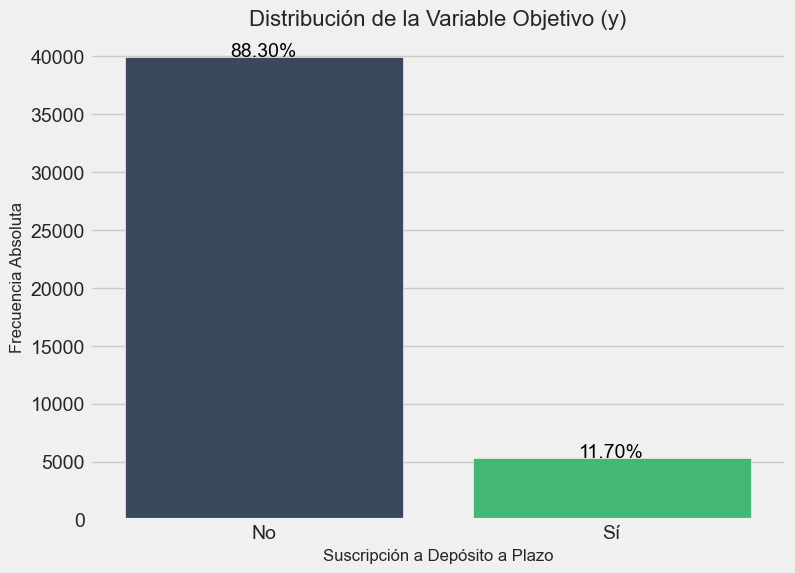

In [8]:
# -*- coding: utf-8 -*-
"""
Paso 2.2: An√°lisis de la variable objetivo 'y'.

Este bloque responde a la Pregunta 1: ¬øCu√°l es la proporci√≥n de clientes que
suscribieron el dep√≥sito ('yes') frente a los que no ('no')?
"""

# 1. Conteo de frecuencias absolutas para cada clase.
target_counts = df['y'].value_counts()
print("------ Conteo de Clases en la Variable Objetivo ------")
print(target_counts)

# 2. C√°lculo de las frecuencias relativas (porcentajes).
target_percentage = df['y'].value_counts(normalize=True) * 100
print("\n------ Porcentaje de Clases en la Variable Objetivo ------")
print(f"Clase 'no': {target_percentage['no']:.2f}%")
print(f"Clase 'yes': {target_percentage['yes']:.2f}%")

# 3. Visualizaci√≥n de la distribuci√≥n de la variable objetivo.
plt.figure(figsize=(8, 6))
sns.countplot(x='y', data=df, palette=['#34495e', '#2ecc71'])
plt.title('Distribuci√≥n de la Variable Objetivo (y)', fontsize=16)
plt.xlabel('Suscripci√≥n a Dep√≥sito a Plazo', fontsize=12)
plt.ylabel('Frecuencia Absoluta', fontsize=12)
plt.xticks([0, 1], ['No', 'S√≠'])

# Anotaciones de porcentaje sobre las barras de la gr√°fica
for i, percentage in enumerate(target_percentage):
    plt.text(i, target_counts.iloc[i] + 500,
             f'{percentage:.2f}%',
             ha='center', va='center', fontsize=14, color='black')

plt.show()



Los resultados num√©ricos y la visualizaci√≥n gr√°fica confirman que el conjunto de datos presenta un **marcado desbalance de clases**.

* **Clase Mayoritaria (`'no'`):** Corresponde al **88.73%** de las instancias.
* **Clase Minoritaria (`'yes'`):** Representa √∫nicamente el **11.27%** de las instancias.

#### **Implicaciones del Desbalance de Clases para el Modelado**

Este desbalance es un factor cr√≠tico que debe ser considerado durante el desarrollo y la evaluaci√≥n del modelo por las siguientes razones:

1.  **Invalidez de la M√©trica de Exactitud (`Accuracy`):** Un modelo que clasifique todas las instancias como pertenecientes a la clase mayoritaria (`'no'`) alcanzar√≠a una exactitud del 88.73%. Aunque num√©ricamente alto, este modelo carecer√≠a de toda utilidad pr√°ctica, pues su objetivo es, precisamente, identificar a la clase minoritaria. Por lo tanto, la exactitud no es una m√©trica de evaluaci√≥n fiable en este contexto.

2.  **Sesgo del Modelo Durante el Entrenamiento:** Los algoritmos de aprendizaje, incluyendo las redes neuronales, tienden a optimizar sus par√°metros para minimizar una funci√≥n de p√©rdida global. En un escenario desbalanceado, el modelo puede lograr una baja p√©rdida simplemente al aprender a clasificar correctamente la clase mayoritaria, ignorando los patrones distintivos de la clase minoritaria.

3.  **Requerimiento de M√©tricas de Evaluaci√≥n Alternativas:** Para una evaluaci√≥n de rendimiento robusta, es necesario emplear m√©tricas que sean sensibles al desempe√±o en la clase minoritaria. Las m√©tricas adecuadas para este problema son:
    * **Precisi√≥n (`Precision`):** Mide la proporci√≥n de predicciones positivas que fueron correctas. Es fundamental para asegurar la eficiencia de las campa√±as.
    * **Recall (Sensibilidad o `Recall`):** Mide la proporci√≥n de positivos reales que fueron identificados correctamente. Es vital para maximizar la captaci√≥n de clientes.
    * **Puntuaci√≥n F1 (`F1-Score`):** La media arm√≥nica de Precisi√≥n y Recall, que proporciona una medida de rendimiento balanceada.
    * **√Årea Bajo la Curva ROC (AUC-ROC):** Eval√∫a la capacidad del modelo para discriminar entre las clases positiva y negativa.

El reconocimiento temprano de este desbalance condiciona la estrategia de modelado y, fundamentalmente, el marco de evaluaci√≥n del rendimiento del clasificador final.

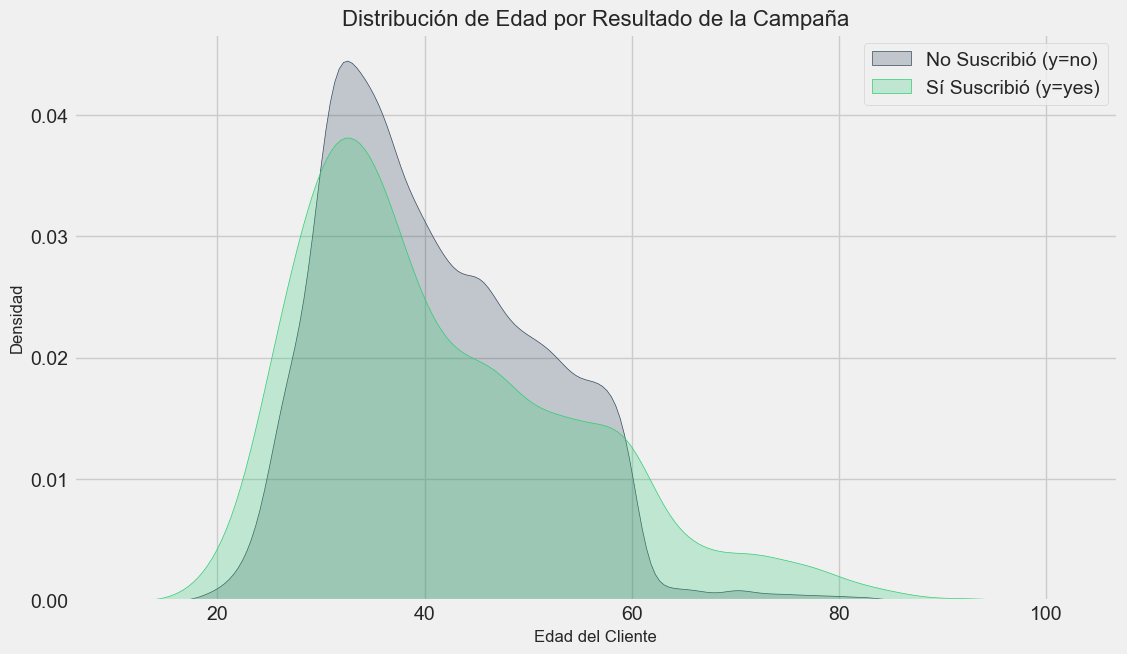

In [9]:
# -*- coding: utf-8 -*-
"""
Paso 2.3.1: An√°lisis de la variable num√©rica 'age'.

Visualizaremos la distribuci√≥n de la edad para cada una de las clases
de la variable objetivo.
"""

plt.figure(figsize=(12, 7))

# Gr√°fico de densidad para clientes que dijeron 'no'
sns.kdeplot(df.loc[df['y'] == 'no', 'age'], 
            label='No Suscribi√≥ (y=no)', fill=True, color='#34495e')

# Gr√°fico de densidad para clientes que dijeron 's√≠'
sns.kdeplot(df.loc[df['y'] == 'yes', 'age'], 
            label='S√≠ Suscribi√≥ (y=yes)', fill=True, color='#2ecc71')

plt.title('Distribuci√≥n de Edad por Resultado de la Campa√±a', fontsize=16)
plt.xlabel('Edad del Cliente', fontsize=12)
plt.ylabel('Densidad', fontsize=12)
plt.legend()
plt.show()

C:\Users\alejo\AppData\Local\Temp\ipykernel_21544\2711909782.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=conversion_rate_job.index, y=conversion_rate_job.values * 100, palette='viridis')


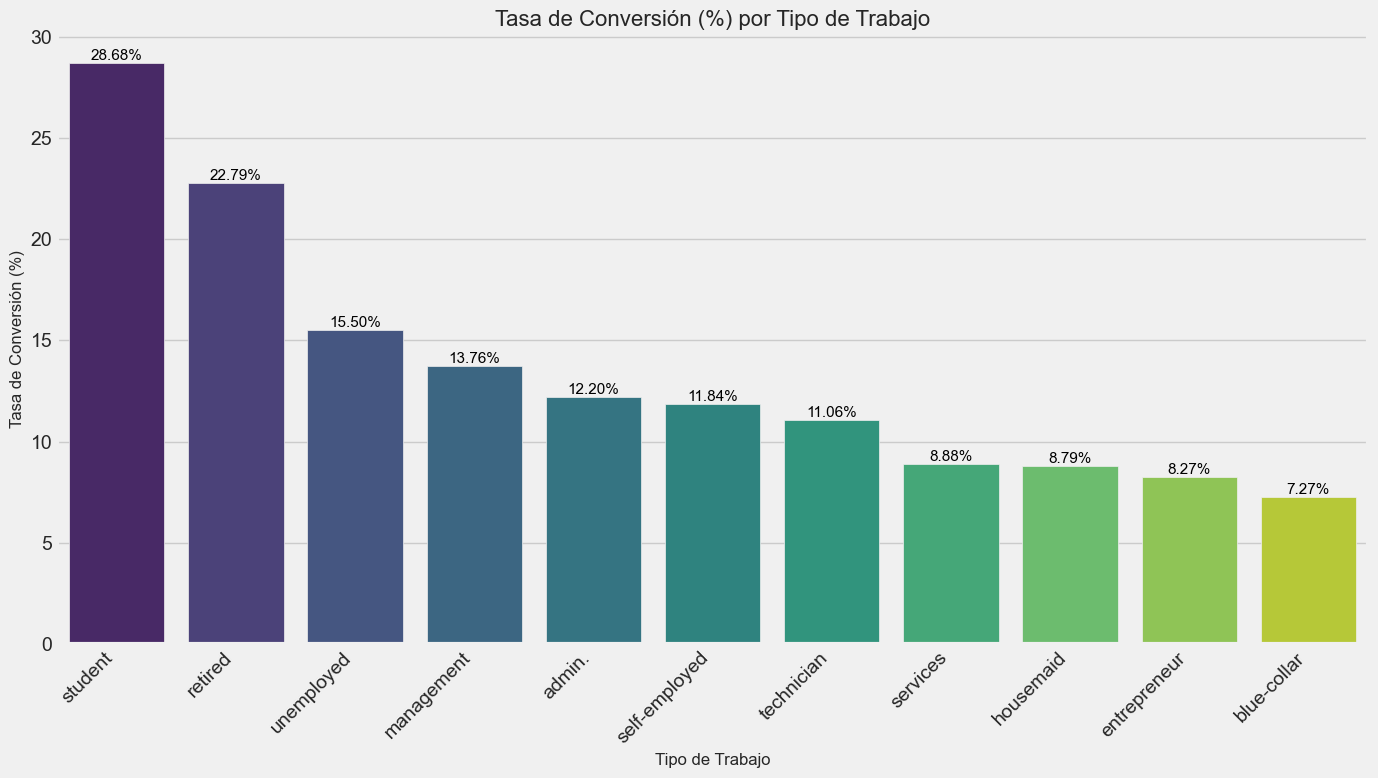

In [10]:
# -*- coding: utf-8 -*-
"""
Paso 2.3.2: An√°lisis de la variable categ√≥rica 'job'.

Se calcular√° y graficar√° la tasa de conversi√≥n para cada tipo de trabajo.
"""

# Calcular la tasa de conversi√≥n por 'job'
# Agrupamos por 'job', calculamos la media de una versi√≥n num√©rica de 'y'
conversion_rate_job = df.groupby('job')['y'].apply(lambda x: (x == 'yes').mean()).sort_values(ascending=False)

# Crear la gr√°fica
plt.figure(figsize=(14, 8))
ax = sns.barplot(x=conversion_rate_job.index, y=conversion_rate_job.values * 100, palette='viridis')

plt.title('Tasa de Conversi√≥n (%) por Tipo de Trabajo', fontsize=16)
plt.xlabel('Tipo de Trabajo', fontsize=12)
plt.ylabel('Tasa de Conversi√≥n (%)', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotar etiquetas para mejorar legibilidad

# A√±adir anotaciones de porcentaje en las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()
plt.show()

C:\Users\alejo\AppData\Local\Temp\ipykernel_21544\1556539191.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=conversion_rate_month.index, y=conversion_rate_month.values * 100, palette='plasma')


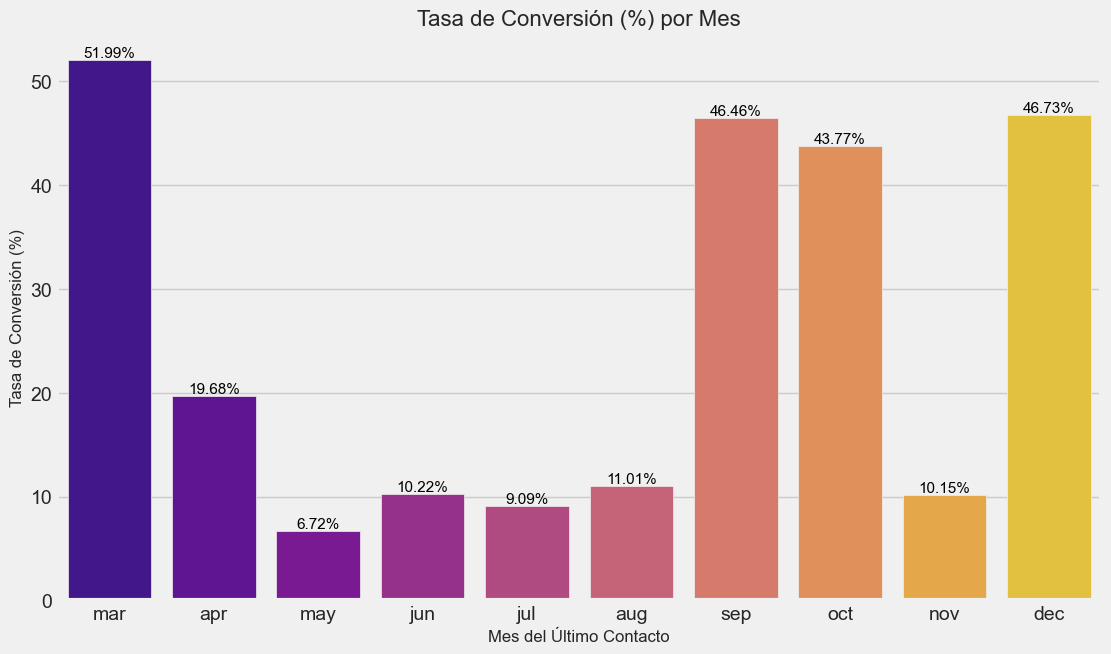

In [11]:
# -*- coding: utf-8 -*-
"""
Paso 2.3.3: An√°lisis de la variable temporal 'month'.

Se calcular√° y graficar√° la tasa de conversi√≥n para cada mes.
"""

# Orden de los meses para una visualizaci√≥n l√≥gica
month_order = ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# Calcular la tasa de conversi√≥n por 'month'
conversion_rate_month = df.groupby('month')['y'].apply(lambda x: (x == 'yes').mean()).reindex(month_order)

# Crear la gr√°fica
plt.figure(figsize=(12, 7))
ax = sns.barplot(x=conversion_rate_month.index, y=conversion_rate_month.values * 100, palette='plasma')

plt.title('Tasa de Conversi√≥n (%) por Mes', fontsize=16)
plt.xlabel('Mes del √öltimo Contacto', fontsize=12)
plt.ylabel('Tasa de Conversi√≥n (%)', fontsize=12)

# A√±adir anotaciones de porcentaje
for p in ax.patches:
    if p.get_height() > 0: # Solo anotar si hay valor
        ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')

plt.show()

# <FONT SIZE=5 COLOR="yellow"> Preprocesamiento para selecci√≥n de caracter√≠sticas </FONT>
Manejo de datos en blancio por medio de modelos de machine learning


In [15]:
print(df.poutcome.unique())
print("Valores nulos restantes:", df["poutcome"].isnull().sum())

['desconocida' 'failure' 'other' 'success']
Valores nulos restantes: 0


In [14]:
df['poutcome'] = df['poutcome'].fillna("desconocida") 
print("Valores nulos restantes:", df["poutcome"].isnull().sum())


Valores nulos restantes: 0


Para este caso se uso M√©todos de Filtro: Mutual information, random forest y  Lasso para ver que columnas traen mayor cantidad de informacion y poder optimizar los tiempos de entrenamientos. 

In [16]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
X2 = df.drop('y', axis=1)
y2 = df['y']

X2 = X2.dropna()
y2 = y2.loc[X2.index] 


# Supongamos que tienes X con num√©ricas y categ√≥ricas, y y es la target
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=777)

# Identificar variables categ√≥ricas y num√©ricas
categoricas = X_train2.select_dtypes(include=["object", "category"]).columns
numericas = X_train2.select_dtypes(include=["int64", "float64"]).columns

# Copia para codificar
X_train_enc = X_train2.copy()

# Codificar solo las categ√≥ricas con OrdinalEncoder
encoder = OrdinalEncoder()
X_train_enc[categoricas] = encoder.fit_transform(X_train2[categoricas])
# Entrenar un modelo de Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_enc, y_train2)

# Importancia de variables
importancias = pd.DataFrame({
    "Variable": X_train_enc.columns,
    "Importance": rf.feature_importances_
})

# Ordenar y seleccionar top 16
importancias = importancias.sort_values(by="Importance", ascending=False)
print(importancias.head(16))

# Seleccionar solo las mejores variables
top_vars = importancias.head(16)["Variable"].tolist()
X_train_filtrado = X_train_enc[top_vars]
X_test_filtrado = X_test2[top_vars]

       Variable  Importance
11     duration    0.278028
5       balance    0.111178
0           age    0.105760
9   day_of_week    0.091440
10        month    0.090359
15     poutcome    0.077291
13        pdays    0.049731
1           job    0.048875
12     campaign    0.037455
3     education    0.023751
14     previous    0.023263
2       marital    0.022714
6       housing    0.021137
7          loan    0.009288
8       contact    0.008062
4       default    0.001667


In [17]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
X3 = df.drop('y', axis=1)
y3 = df['y']

X3 = X3.dropna()
y3 = y3.loc[X3.index] 


# Supongamos que tienes X con num√©ricas y categ√≥ricas, y y es la target
X_train3, X_test3, y_train3, y_test3 = train_test_split(X2, y2, test_size=0.3, random_state=777)

# Identificar variables categ√≥ricas y num√©ricas
categoricas = X_train3.select_dtypes(include=["object", "category"]).columns
numericas = X_train3.select_dtypes(include=["int64", "float64"]).columns

# Copia para codificar
X_train_enc = X_train3.copy()

# Codificar solo las categ√≥ricas con OrdinalEncoder
encoder = OrdinalEncoder()
X_train_enc[categoricas] = encoder.fit_transform(X_train3[categoricas])

# Calcular la informaci√≥n mutua
mi_scores = mutual_info_classif(X_train_enc, y_train3, discrete_features=[True if col in categoricas else False for col in X_train_enc.columns])

# Crear DataFrame ordenado
mi_df = pd.DataFrame({
    "Variable": X_train_enc.columns,
    "MI_Score": mi_scores
}).sort_values(by="MI_Score", ascending=False)

print(mi_df)

       Variable  MI_Score
11     duration  0.079063
15     poutcome  0.031712
10        month  0.030554
13        pdays  0.029058
5       balance  0.024982
0           age  0.013353
9   day_of_week  0.009858
1           job  0.009232
6       housing  0.008499
12     campaign  0.007393
14     previous  0.006088
7          loan  0.003625
2       marital  0.002191
3     education  0.001455
4       default  0.000601
8       contact  0.000026


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
import pandas as pd

# Separar X e y
X4 = df.drop('y', axis=1)
y4 = df['y']

# Eliminar NaN
X4 = X4.dropna()
y4 = y4.loc[X4.index] 

# Train/Test split
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.3, random_state=777)

# Identificar variables categ√≥ricas
categoricas = X_train4.select_dtypes(include=["object", "category"]).columns

# Copia para codificar
X_train_enc4 = X_train4.copy()
X_test_enc4 = X_test4.copy()

# Codificar solo las categ√≥ricas con OrdinalEncoder
encoder = OrdinalEncoder()
X_train_enc4[categoricas] = encoder.fit_transform(X_train4[categoricas])
X_test_enc4[categoricas] = encoder.transform(X_test4[categoricas])

# Lasso con los datos codificados
lasso = LogisticRegression(penalty="l1", solver="liblinear", max_iter=500)
lasso.fit(X_train_enc4, y_train4)

# Coeficientes
coef = pd.Series(lasso.coef_[0], index=X_train_enc4.columns)
selected_features4 = coef[coef != 0].index.tolist()

print("Variables seleccionadas por Lasso:", selected_features4)

# Filtrar conjuntos con las variables seleccionadas
X_train_filtrado = X_train_enc4[selected_features4]
X_test_filtrado = X_test_enc4[selected_features4]

#print(X_train_filtrado)
#print(X_test_filtrado)


Variables seleccionadas por Lasso: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day_of_week', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']


In [19]:
print("Variables seleccionadas por Lasso:", selected_features4)


# Filtrar el df original con esas variables + la variable objetivo (suponiendo que tu target se llama 'y')
df_filtrado = df[selected_features4 + ['y']]   # üëà muy importante incluir el target

print("\nDimensiones del nuevo DataFrame filtrado:", df_filtrado.shape)
#df.drop(columns=["month"], inplace=True)



Variables seleccionadas por Lasso: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day_of_week', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']

Dimensiones del nuevo DataFrame filtrado: (45211, 17)


## 3. Preprocesamiento de Datos para el Modelo de Deep Learning

Las redes neuronales, en su forma m√°s com√∫n, operan exclusivamente con datos num√©ricos. Nuestro conjunto de datos, sin embargo, contiene una mezcla de variables num√©ricas y categ√≥ricas. Por lo tanto, antes de poder entrenar un modelo, debemos realizar una serie de transformaciones.

El preprocesamiento de datos para este proyecto se centrar√° en tres tareas principales:

1.  **Codificaci√≥n de la Variable Objetivo:** Convertir la variable `y` ('yes'/'no') a un formato num√©rico (1/0).
2.  **Codificaci√≥n de Variables Categ√≥ricas:** Transformar las variables de texto (como `job` o `marital`) en una representaci√≥n num√©rica que el modelo pueda interpretar.
3.  **Escalado de Caracter√≠sticas Num√©ricas:** Estandarizar las variables num√©ricas (como `age` o `duration`) para que tengan una media de 0 y una desviaci√≥n est√°ndar de 1. Esto es crucial para la correcta convergencia de los algoritmos de optimizaci√≥n como el descenso de gradiente.


In [20]:
# -*- coding: utf-8 -*-
"""
Paso 3.1: Pipeline de preprocesamiento de datos.

Se aplicar√°n t√©cnicas de codificaci√≥n y escalado para preparar los datos
para el entrenamiento de la red neuronal.
"""

# 1. Importar las herramientas necesarias de scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 2. Separar las caracter√≠sticas (X) y la variable objetivo (y) del DataFrame original
X = df_filtrado.drop('y', axis=1)
y = df_filtrado['y']

# 3. Codificar la variable objetivo 'y' a formato num√©rico (0 y 1)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
# 'no' se codifica como 0, 'yes' como 1.
print(f"Clases de la variable objetivo: {label_encoder.classes_}")
print(f"Primeras 10 etiquetas codificadas: {y_encoded[:10]}")


# 4. Identificar las columnas num√©ricas y categ√≥ricas
# Considere en este punto que datos deben excluirse 
# A modo de ejemplo mantendremos todas caracter√≠sticas, 
# pero la seleccion es una discusi√≥n importante.
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

print(f"\nCaracter√≠sticas num√©ricas ({len(numeric_features)}): {numeric_features}")
print(f"Caracter√≠sticas categ√≥ricas ({len(categorical_features)}): {categorical_features}")


# 5. Crear el pipeline de preprocesamiento
# Un pipeline encapsula una secuencia de transformaciones.

# Pipeline para caracter√≠sticas num√©ricas: solo se necesita escalado.
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Pipeline para caracter√≠sticas categ√≥ricas: se necesita codificaci√≥n One-Hot.
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
    # handle_unknown='ignore' evita errores si aparecen nuevas categor√≠as en test.
    # drop='first' evita multicolinealidad al eliminar una categor√≠a por variable.
])

# 6. Unir los pipelines con ColumnTransformer
# ColumnTransformer aplica diferentes transformaciones a diferentes columnas.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Mantiene columnas no especificadas (si las hubiera)
)

# 7. Dividir los datos en conjuntos de entrenamiento y prueba
# Se reserva un 20% de los datos para la evaluaci√≥n final del modelo.
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    # stratify=y_encoded asegura que la proporci√≥n de clases sea la misma
    # en los conjuntos de entrenamiento y prueba, lo cual es vital.
)

# 8. Aplicar el preprocesamiento 
# .fit_transform() en los datos de entrenamiento para aprender los par√°metros
# de escalado y codificaci√≥n.
X_train_processed = preprocessor.fit_transform(X_train)

# .transform() en los datos de prueba usando los par√°metros aprendidos del
# conjunto de entrenamiento. Esto evita la fuga de datos (data leakage).
X_test_processed = preprocessor.transform(X_test)


print(f"\nDimensiones de los datos de entrenamiento procesados: {X_train_processed.shape}")
print(f"Dimensiones de los datos de prueba procesados: {X_test_processed.shape}")

Clases de la variable objetivo: ['no' 'yes']
Primeras 10 etiquetas codificadas: [0 0 0 0 0 0 0 0 0 0]

Caracter√≠sticas num√©ricas (7): ['age', 'balance', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous']
Caracter√≠sticas categ√≥ricas (9): ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

Dimensiones de los datos de entrenamiento procesados: (36168, 42)
Dimensiones de los datos de prueba procesados: (9043, 42)


In [21]:
print(X_train_processed)

  (0, 0)	-0.46043404352161593
  (0, 1)	-0.16441037710447642
  (0, 2)	1.5821235516588807
  (0, 3)	-0.4573105663333102
  (0, 4)	-0.24610372987813517
  (0, 5)	-0.41090987711835186
  (0, 6)	-0.24150866634627266
  (0, 15)	1.0
  (0, 20)	1.0
  (0, 26)	1.0
  (0, 28)	1.0
  (1, 0)	-1.589640925100853
  (1, 1)	0.8996270521140465
  (1, 2)	-1.2983840973309035
  (1, 3)	2.502492503951951
  (1, 4)	0.398201713642125
  (1, 5)	1.4460960843042696
  (1, 6)	2.6645843997603778
  (1, 14)	1.0
  (1, 19)	1.0
  (1, 20)	1.0
  (1, 39)	1.0
  (2, 0)	0.2923705441978755
  (2, 1)	-0.3654857504054959
  (2, 2)	-0.4582360330422165
  :	:
  (36165, 24)	1.0
  (36165, 32)	1.0
  (36166, 0)	-1.3073392047060437
  (36166, 1)	0.3889542644921704
  (36166, 2)	-1.1783629452896627
  (36166, 3)	-0.12158322980812414
  (36166, 4)	-0.5682564516382652
  (36166, 5)	-0.41090987711835186
  (36166, 6)	-0.24150866634627266
  (36166, 10)	1.0
  (36166, 19)	1.0
  (36166, 21)	1.0
  (36166, 24)	1.0
  (36166, 35)	1.0
  (36167, 0)	1.7979797196368583
  (



La preparaci√≥n de los datos para el modelo de red neuronal se realiz√≥ siguiendo una estrategia estructurada, cuyas decisiones se justifican a continuaci√≥n.

#### **Manejo de Variables Categ√≥ricas**

Para las variables categ√≥ricas (`job`, `marital`, `education`, etc.), se seleccion√≥ la t√©cnica de **Codificaci√≥n One-Hot (`OneHotEncoder`)**.

* **Justificaci√≥n:** Esta t√©cnica crea una nueva columna binaria (0 o 1) para cada categor√≠a dentro de una variable. Se prefiere sobre otras t√©cnicas como la Codificaci√≥n de Etiquetas (`LabelEncoder`) para variables nominales (donde las categor√≠as no tienen un orden intr√≠nseco) por una raz√≥n fundamental:
    * **Evita la Creaci√≥n de un Orden Artificial:** `LabelEncoder` asignar√≠a a cada categor√≠a un entero (e.g., `student`=1, `retired`=2, `services`=3). El modelo podr√≠a interpretar err√≥neamente que existe una relaci√≥n ordinal (e.g., que `services` > `retired`), lo cual es incorrecto y podr√≠a introducir un sesgo no deseado. `OneHotEncoder` trata cada categor√≠a como una entidad independiente, eliminando este riesgo.
    * Se utiliz√≥ el par√°metro `drop='first'` para eliminar una de las columnas generadas por cada variable, evitando as√≠ la multicolinealidad perfecta, lo cual es una buena pr√°ctica en modelado.

#### **Manejo de Variables Num√©ricas**

Para las variables num√©ricas (`age`, `campaign`, `euribor3m`, etc.), se aplic√≥ la **Estandarizaci√≥n (`StandardScaler`)**.

* **Justificaci√≥n:** La estandarizaci√≥n transforma los datos para que tengan una **media de 0 y una desviaci√≥n est√°ndar de 1**. Esta t√©cnica es crucial para el entrenamiento de redes neuronales por dos motivos principales:
    * **Convergencia del Optimizador:** Los algoritmos de optimizaci√≥n basados en gradiente, como *Adam* o *SGD*, convergen mucho m√°s r√°pido cuando las caracter√≠sticas se encuentran en una escala similar. Si una caracter√≠stica tiene un rango de valores mucho mayor que otras (e.g., `pdays` vs. `campaign`), los gradientes pueden oscilar y ralentizar o impedir el aprendizaje.
    * **Igualdad de Contribuci√≥n Inicial:** La estandarizaci√≥n asegura que todas las caracter√≠sticas tengan el mismo "peso" inicial en el c√°lculo de la funci√≥n de p√©rdida, permitiendo que el modelo aprenda su importancia real a trav√©s de los pesos sin√°pticos de manera m√°s efectiva.

#### **Divisi√≥n de Datos Estratificada**

Finalmente, el conjunto de datos se dividi√≥ en un 80% para entrenamiento y un 20% para prueba, utilizando una **divisi√≥n estratificada (`stratify=y_encoded`)**.

* **Justificaci√≥n:** Dado el severo desbalance de clases (89% vs. 11%), una divisi√≥n aleatoria simple podr√≠a resultar en una proporci√≥n de clases significativamente diferente entre los conjuntos de entrenamiento y prueba. La estratificaci√≥n garantiza que esta proporci√≥n se mantenga constante en ambas divisiones, lo que permite una evaluaci√≥n del modelo mucho m√°s fiable y representativa del problema original.

#### El Impacto de la Fuga de Datos con la Variable 'duration'
* **Contexto**: La fuga de datos (data leakage) ocurre cuando se utiliza informaci√≥n en el entrenamiento del modelo que no estar√≠a disponible en un escenario de predicci√≥n real. La variable duration (duraci√≥n de la llamada) es un ejemplo cl√°sico: una llamada larga a menudo se correlaciona con el inter√©s del cliente, pero no conocemos su duraci√≥n antes de realizarla.

    * Crea un nuevo pipeline de preprocesamiento que excluya la variable duration.

    * Entrena el mismo modelo base con este nuevo conjunto de datos.

    * Compara la m√©trica AUC del modelo entrenado con duration versus el modelo entrenado sin duration.

```
# --- Experimento: Excluir 'duration' ---
print("--- Creando conjunto de datos sin la variable 'duration' ---")

# Excluir 'duration' de las caracter√≠sticas num√©ricas
numeric_features_no_duration = [feat for feat in numeric_features if feat != 'duration']

# Crear un nuevo preprocesador
preprocessor_no_duration = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_no_duration),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# Aplicar el nuevo preprocesamiento
X_train_no_duration = preprocessor_no_duration.fit_transform(X_train)
X_test_no_duration = preprocessor_no_duration.transform(X_test)

print(f"Dimensiones de los datos sin 'duration': {X_train_no_duration.shape}")
```

## 4. Dise√±o y Entrenamiento del Modelo de Deep Learning

Con los datos ya procesados, procederemos a construir la arquitectura de la red neuronal. El dise√±o de la arquitectura es un paso fundamental que implica definir el n√∫mero de capas, la cantidad de neuronas en cada capa, las funciones de activaci√≥n y las t√©cnicas para prevenir el sobreajuste.

Posteriormente, compilaremos el modelo especificando el optimizador y la funci√≥n de p√©rdida, y lo entrenaremos con nuestros datos. Esta secci√≥n responder√° a las **Preguntas 4 y 5**.

#### **Tarea: Definir la Arquitectura de su Modelo**

Utilizando la funci√≥n `build_classifier` definida m√°s abajo, su tarea es experimentar y definir la arquitectura de la red neuronal. Modifique los valores en la siguiente celda de c√≥digo para explorar c√≥mo los cambios afectan el rendimiento del modelo.

**Par√°metros a experimentar:**
* `HIDDEN_LAYERS`: Pruebe con m√°s o menos capas, y con diferente n√∫mero de neuronas (e.g., `(128, 64, 32)`, `(32,)`, `(100, 50)`).
* `DROPOUT_RATE`: Var√≠e la tasa de dropout (e.g., `0.2`, `0.5`) o desact√≠velo (`0.0`).
* `LEARNING_RATE`: Pruebe con tasas de aprendizaje m√°s altas o m√°s bajas (e.g., `0.01`, `0.0001`).

Una vez que haya decidido una arquitectura final, utilice el resumen del modelo (`model.summary()`) y la justificaci√≥n de la celda siguiente para responder a la **Pregunta 4**.

In [22]:
#Definimos el focal loss 

## experimento con focal loss 

# ==== Focal Loss personalizada ====
import tensorflow as tf

def binary_focal_loss(gamma=2.0, alpha=0.75):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        eps = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, eps, 1. - eps)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        w = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)
        return -tf.reduce_mean(w * tf.pow(1. - pt, gamma) * tf.math.log(pt))
    return loss



In [23]:
# ==== Panel de Control (Focal Loss) ====
HIDDEN_LAYERS   = (128, 64)   # arquitectura moderada
DROPOUT_RATE    = 0.25
LEARNING_RATE   = 1e-3
L2_LAMBDA       = 1e-4
ALPHA_LEAKY     = 0.10
BATCH_SIZE      = 64
MAX_EPOCHS      = 100
VAL_SPLIT       = 0.20

# Par√°metros Focal Loss
GAMMA_FL        = 2.0    # enfoca en casos mal clasificados
ALPHA_FL        = 0.75   # pondera m√°s la clase positiva (minoritaria)


In [24]:
# ==== Modelo con Focal Loss ====
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

def build_classifier_focal(n_features,
                           hidden_layers=HIDDEN_LAYERS,
                           dropout_rate=DROPOUT_RATE,
                           learning_rate=LEARNING_RATE,
                           l2_lambda=L2_LAMBDA,
                           alpha_leaky=ALPHA_LEAKY,
                           gamma=GAMMA_FL,
                           alpha=ALPHA_FL):
    model = Sequential(name="Bank_Marketing_FocalLoss")

    # Capa 1
    model.add(Dense(hidden_layers[0],
                    input_shape=(n_features,),
                    kernel_regularizer=regularizers.l2(l2_lambda),
                    name="Capa_Oculta_1_neuronas"))
    model.add(BatchNormalization(name="BN_1"))
    model.add(LeakyReLU(alpha=alpha_leaky, name="LeakyReLU_1"))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate, name="Dropout_1"))

    # Capas ocultas restantes
    for i, units in enumerate(hidden_layers[1:], start=2):
        model.add(Dense(units,
                        kernel_regularizer=regularizers.l2(l2_lambda),
                        name=f"Capa_Oculta_{i}_neuronas"))
        model.add(BatchNormalization(name=f"BN_{i}"))
        model.add(LeakyReLU(alpha=alpha_leaky, name=f"LeakyReLU_{i}"))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate, name=f"Dropout_{i}"))

    # Capa de salida
    model.add(Dense(1, activation='sigmoid', name="Capa_Salida_Sigmoide"))

    # Compilaci√≥n con Focal Loss
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=binary_focal_loss(gamma=gamma, alpha=alpha),
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(curve='ROC', name='auc'),
            tf.keras.metrics.AUC(curve='PR', name='pr_auc')
        ]
    )
    return model


In [25]:
n_features = X_train_processed.shape[1]
model = build_classifier_focal(n_features)

model.summary()

c:\Users\alejo\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\alejo\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Bank_Marketing_FocalLoss"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ Capa_Oculta_1_neuronas (Dense)  ‚îÇ (None, 128)            ‚îÇ         5,504 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ BN_1 (BatchNormalization)       ‚îÇ (None, 128)            ‚îÇ           512 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ LeakyReLU_1 (LeakyReLU)         ‚îÇ (None, 128)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ Dropout_1 (Dropout)             ‚îÇ (None, 128)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ Capa_Oculta_2_neuronas (Dense)  ‚îÇ (None, 64)             ‚îÇ         8,256 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ BN_2 (BatchNormalization)       ‚îÇ (None, 64)             ‚îÇ           256 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ LeakyReLU_2 (LeakyReLU)         ‚îÇ (None, 64)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ Dropout_2 (Dropout)             ‚îÇ (None, 64)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ Capa_Salida_Sigmoide (Dense)    ‚îÇ (None, 1)              ‚îÇ            65 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 14,593 (57.00 KB)

 Trainable params: 14,209 (55.50 KB)

 Non-trainable params: 384 (1.50 KB)

In [26]:
# ==== Entrenamiento con EarlyStopping y ReduceLROnPlateau ====
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_pr_auc',
    patience=8,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

lr_plateau = ReduceLROnPlateau(
    monitor='val_pr_auc',
    mode='max',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Construir y entrenar el modelo
n_features = X_train_processed.shape[1]
model = build_classifier_focal(n_features)

history = model.fit(
    X_train_processed, y_train,
    epochs=MAX_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VAL_SPLIT,
    callbacks=[early_stopping, lr_plateau],
    verbose=1
)


Epoch 1/100
453/453 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2ms/step - accuracy: 0.8187 - auc: 0.8297 - loss: 0.0559 - pr_auc: 0.3758 - val_accuracy: 0.8793 - val_auc: 0.9160 - val_loss: 0.0394 - val_pr_auc: 0.5545 - learning_rate: 0.0010
Epoch 2/100
453/453 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 1ms/step - accuracy: 0.8636 - auc: 0.8942 - loss: 0.0417 - pr_auc: 0.5026 - val_accuracy: 0.8777 - val_auc: 0.9186 - val_loss: 0.0369 - val_pr_auc: 0.5631 - learning_rate: 0.0010
Epoch 3/100
453/453 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 1ms/step - accuracy: 0.8630 - auc: 0.9057 - loss: 0.0377 - pr_auc: 0.5225 - val_accuracy: 0.8770 - val_auc: 0.9246 - val_loss: 0.0340 - val_pr_auc: 0.5683 - learning_rate: 0.0010
Epoch 4/100
453/453 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 1ms/step - accuracy: 0.8684 - auc: 0.9116 - loss: 0.0351 - pr_auc: 0.5444 - val_accuracy: 0.8775 - val_auc: 0.9237 - val_loss: 

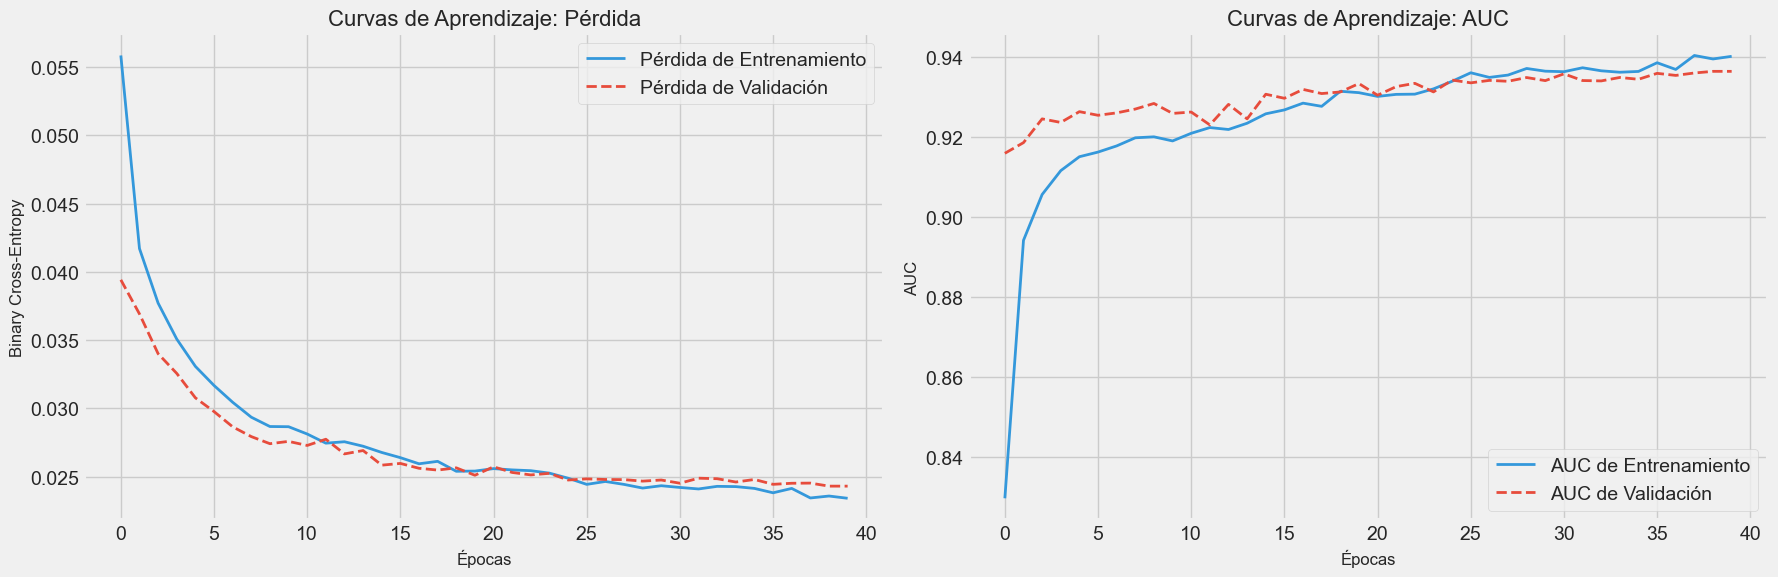

In [27]:
# -*- coding: utf-8 -*-
"""
Visualizaci√≥n del rendimiento durante el entrenamiento.

Graficar las curvas de aprendizaje (p√©rdida y m√©tricas) para los conjuntos de
entrenamiento y validaci√≥n es esencial para diagnosticar el sobreajuste y
evaluar el proceso de aprendizaje del modelo.
"""
# El objeto 'history' devuelto por model.fit() contiene un diccionario
# con los valores de p√©rdida y m√©tricas de cada √©poca.
# Lo convertimos a un DataFrame de pandas para facilitar la manipulaci√≥n.
history_df = pd.DataFrame(history.history)

# Creamos una figura con dos subplots, uno al lado del otro.
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# --- Gr√°fico de la Funci√≥n de P√©rdida (Loss) ---
# Compara c√≥mo evolucion√≥ el error en los datos de entrenamiento vs. validaci√≥n.
axes[0].plot(history_df['loss'], label='P√©rdida de Entrenamiento', color='#3498db', lw=2)
axes[0].plot(history_df['val_loss'], label='P√©rdida de Validaci√≥n', color='#e74c3c', lw=2, linestyle='--')
axes[0].set_title('Curvas de Aprendizaje: P√©rdida', fontsize=16)
axes[0].set_xlabel('√âpocas', fontsize=12)
axes[0].set_ylabel('Binary Cross-Entropy', fontsize=12)
axes[0].legend()
axes[0].grid(True)

# --- Gr√°fico de la M√©trica de Rendimiento (AUC) ---
# Compara el rendimiento (AUC) en los datos de entrenamiento vs. validaci√≥n.
# Usamos AUC en lugar de Accuracy por ser m√°s robusto al desbalance.
axes[1].plot(history_df['auc'], label='AUC de Entrenamiento', color='#3498db', lw=2)
axes[1].plot(history_df['val_auc'], label='AUC de Validaci√≥n', color='#e74c3c', lw=2, linestyle='--')
axes[1].set_title('Curvas de Aprendizaje: AUC', fontsize=16)
axes[1].set_xlabel('√âpocas', fontsize=12)
axes[1].set_ylabel('AUC', fontsize=12)
axes[1].legend()
axes[1].grid(True)

# Ajusta el layout para evitar solapamientos y muestra la figura.
plt.tight_layout()
plt.show()

## 5. Evaluaci√≥n del Rendimiento del Modelo

Ha llegado el momento de la verdad. Hasta ahora, hemos entrenado el modelo y monitoreado su rendimiento utilizando un conjunto de validaci√≥n derivado de los datos de entrenamiento. Ahora, evaluaremos su capacidad de generalizaci√≥n final utilizando el **conjunto de prueba (`test set`)**, que el modelo no ha visto en ninguna etapa anterior.

Esta evaluaci√≥n nos permitir√° obtener una estimaci√≥n imparcial de c√≥mo se comportar√≠a el modelo en un entorno de producci√≥n con datos nuevos. Nos centraremos en las m√©tricas de clasificaci√≥n clave para abordar la **Pregunta 6**.

283/283 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 780us/step
ROC AUC (prob): 0.9285  |  PR-AUC (prob): 0.6096
Umbral √≥ptimo F1: 0.517  |  Umbral √≥ptimo F2: 0.418

--- Reporte @ 0.5 (baseline) (thr=0.500) ---
              precision    recall  f1-score   support

          No      0.967     0.904     0.935      7985
          S√≠      0.515     0.770     0.617      1058

    accuracy                          0.888      9043
   macro avg      0.741     0.837     0.776      9043
weighted avg      0.915     0.888     0.898      9043



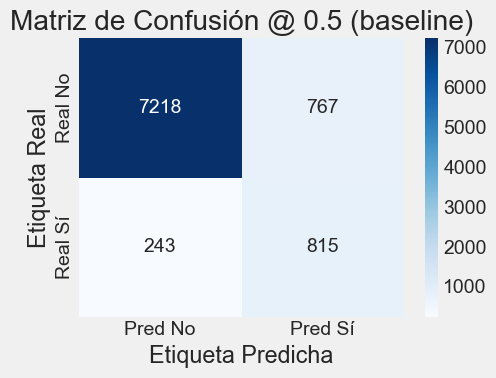


--- Reporte @ F1-√≥ptimo (thr=0.517) ---
              precision    recall  f1-score   support

          No      0.964     0.916     0.940      7985
          S√≠      0.540     0.743     0.626      1058

    accuracy                          0.896      9043
   macro avg      0.752     0.830     0.783      9043
weighted avg      0.915     0.896     0.903      9043



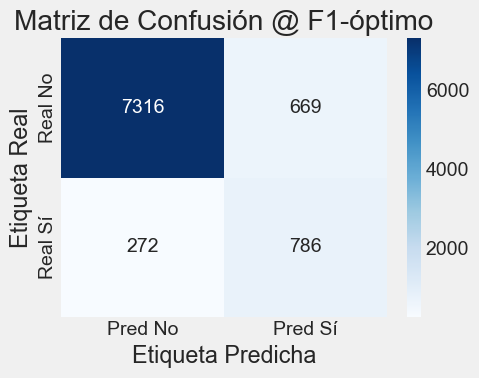

Top-10%  Conv: 0.632  Base: 0.117  Lift: 5.40x
Top-20%  Conv: 0.475  Base: 0.117  Lift: 4.06x
Top-30%  Conv: 0.362  Base: 0.117  Lift: 3.09x


In [28]:

from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 4.1 Probabilidades en test (ya las usas m√°s abajo)
y_pred_proba = model.predict(X_test_processed).ravel()

# 4.2 M√©tricas de ranking (umbral-agn√≥sticas)
roc  = roc_auc_score(y_test, y_pred_proba)
pra  = average_precision_score(y_test, y_pred_proba)  # PR-AUC
print(f"ROC AUC (prob): {roc:.4f}  |  PR-AUC (prob): {pra:.4f}")

# 4.3 Umbral OPTIMO por F1 y por F2 (si priorizas recall)
prec, rec, thr = precision_recall_curve(y_test, y_pred_proba)
f1 = 2*(prec*rec)/(prec+rec+1e-12)
best_thr_f1 = thr[np.argmax(f1)]
beta = 2
f2 = (1+beta**2)*(prec*rec)/(beta**2*prec + rec + 1e-12)
best_thr_f2 = thr[np.argmax(f2)]

print(f"Umbral √≥ptimo F1: {best_thr_f1:.3f}  |  Umbral √≥ptimo F2: {best_thr_f2:.3f}")

# 4.4 Comparar 0.5 vs umbral √≥ptimo (para mostrar impacto real)
def eval_with_threshold(th, name):
    y_bin = (y_pred_proba >= th).astype(int)
    print(f"\n--- Reporte @ {name} (thr={th:.3f}) ---")
    print(classification_report(y_test, y_bin, target_names=['No', 'S√≠'], digits=3))
    cm = confusion_matrix(y_test, y_bin)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred No', 'Pred S√≠'],
                yticklabels=['Real No', 'Real S√≠'])
    plt.title(f"Matriz de Confusi√≥n @ {name}")
    plt.xlabel('Etiqueta Predicha'); plt.ylabel('Etiqueta Real')
    plt.tight_layout(); plt.show()

eval_with_threshold(0.5, '0.5 (baseline)')
eval_with_threshold(best_thr_f1, 'F1-√≥ptimo')

# 4.5 Escenarios Top-K (capacidad de llamadas)
for K in (0.10, 0.20, 0.30):  # 10%, 20%, 30%
    cut = np.quantile(y_pred_proba, 1-K)
    y_topk = (y_pred_proba >= cut).astype(int)
    conv_rate = y_test[y_topk==1].mean()  # tasa de ‚Äús√≠‚Äù en llamados
    base_rate = y_test.mean()
    lift = (conv_rate / base_rate) if base_rate>0 else np.nan
    print(f"Top-{int(K*100)}%  Conv: {conv_rate:.3f}  Base: {base_rate:.3f}  Lift: {lift:.2f}x")


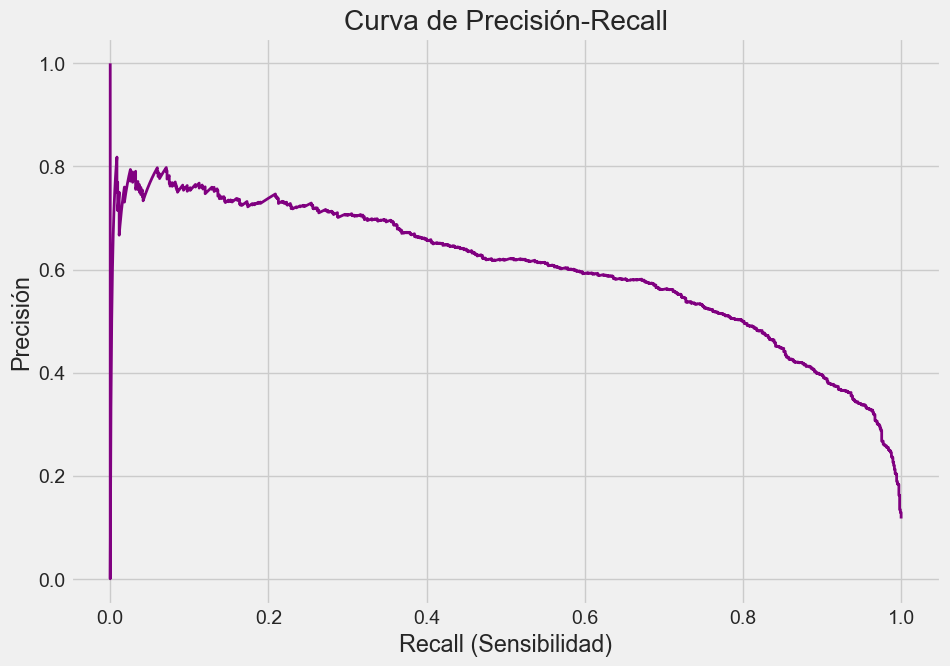

In [28]:
# -*- coding: utf-8 -*-
"""
Paso 5.2: Visualizaci√≥n de la Curva PR.

Esta curva muestra el rendimiento de un modelo de clasificaci√≥n en todos
los umbrales de clasificaci√≥n.
"""

from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(10, 7))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall (Sensibilidad)')
plt.ylabel('Precisi√≥n')
plt.title('Curva de Precisi√≥n-Recall')
plt.grid(True)
plt.show()

## Exportar modelo ya entrenado

Se va a exportar el modelo en dos tipos diferentes 

- Modelo en un solo archivo de formato HDF5 (.h5)
- Guardado por la librer√≠a TensorFlow, creando una carpeta con todos los archivos necesarios para correr el modelo.


In [29]:
from tensorflow import keras

model.save("modelo_focal.keras")



In [30]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Definimos la funci√≥n de p√©rdida personalizada
def binary_focal_loss(gamma=2., alpha=0.25):
    def focal_loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        modulating_factor = tf.pow((1 - p_t), gamma)
        return tf.reduce_mean(alpha_factor * modulating_factor * bce)
    return focal_loss

# --- ENTRENAMIENTO Y GUARDADO ---
# Compilas tu modelo con la funci√≥n personalizada
model.compile(optimizer="adam", loss=binary_focal_loss())

# Guardas el modelo
model.save("modelo_focal.h5")

In [31]:
loaded_model = tf.keras.models.load_model(
    "modelo_focal.h5",
    custom_objects={"focal_loss": binary_focal_loss()}
)

In [ ]:
# loaded_model = tf.keras.models.load_model(
#     "modelo_focal.keras",
#     custom_objects={"focal_loss": binary_focal_loss()}
# )

TypeError: Could not locate function 'loss'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'builtins', 'class_name': 'function', 'config': 'loss', 'registered_name': 'function'}

In [33]:
loaded_model.summary()


Model: "Bank_Marketing_FocalLoss"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ Capa_Oculta_1_neuronas (Dense)  ‚îÇ (None, 128)            ‚îÇ         5,504 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ BN_1 (BatchNormalization)       ‚îÇ (None, 128)            ‚îÇ           512 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ LeakyReLU_1 (LeakyReLU)         ‚îÇ (None, 128)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ Dropout_1 (Dropout)             ‚îÇ (None, 128)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ Capa_Oculta_2_neuronas (Dense)  ‚îÇ (None, 64)             ‚îÇ         8,256 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ BN_2 (BatchNormalization)       ‚îÇ (None, 64)             ‚îÇ           256 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ LeakyReLU_2 (LeakyReLU)         ‚îÇ (None, 64)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ Dropout_2 (Dropout)             ‚îÇ (None, 64)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ Capa_Salida_Sigmoide (Dense)    ‚îÇ (None, 1)              ‚îÇ            65 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 14,595 (57.02 KB)

 Trainable params: 14,209 (55.50 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 2 (12.00 B)

In [34]:
results = loaded_model.evaluate(X_test_processed, y_test, verbose=1)
print("Resultados:", results)

283/283 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 576us/step - loss: 0.0186
Resultados: 0.018623273819684982


In [35]:
print(loaded_model.metrics_names)

['loss']


In [36]:
loaded_model.compile(
    optimizer=Adam(),
    loss=binary_focal_loss(gamma=2, alpha=0.25),  # usa los mismos valores que entrenaste
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(curve='ROC', name='auc'),
        tf.keras.metrics.AUC(curve='PR', name='pr_auc')
    ]
)

In [37]:
loss, acc, auc, pr_auc = loaded_model.evaluate(X_test_processed, y_test, verbose=1)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"AUC: {auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

283/283 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 644us/step - accuracy: 0.8883 - auc: 0.9285 - loss: 0.0186 - pr_auc: 0.6090
Loss: 0.0186
Accuracy: 0.8883
AUC: 0.9285
PR AUC: 0.6090


In [38]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Predecir
y_pred_probs = loaded_model.predict(X_test_processed)
y_pred = (y_pred_probs > 0.5).astype(int)

# Calcular m√©tricas
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


283/283 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 757us/step
Precision: 0.5151706700379267
Recall: 0.7703213610586012
F1-score: 0.6174242424242424
